In [1]:
!pip install torch transformers datasets nltk pandas matplotlib seaborn plotly scikit-learn evaluate rouge-score

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import BertTokenizer, T5Tokenizer, GPT2Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import nltk
from concurrent.futures import ProcessPoolExecutor

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Load the dataset
dataset = load_dataset("toughdata/quora-question-answer-dataset")["train"].to_pandas()

# Data Exploration
print(dataset.head())
print(dataset.info())
print(dataset.describe())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/56402 [00:00<?, ? examples/s]

                                            question  \
0  Why whenever I get in the shower my girlfriend...   
1            What is a proxy, and how can I use one?   
2  What song has the lyrics "someone left the cak...   
3  I am the owner of an adult website called http...   
4  Does the Bible mention anything about a place ...   

                                              answer  
0  Isn’t it awful? You would swear that there was...  
1  A proxy server is a system or router that prov...  
2                                 MacArthur's Park\n  
3  Don't let apps that are liers put adds on your...  
4  St. John in the book of Revelation mentions an...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56402 entries, 0 to 56401
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  56402 non-null  object
 1   answer    56402 non-null  object
dtypes: object(2)
memory usage: 881.4+ KB
None
                          

In [4]:
# Check for null values
print(dataset.isnull().sum())

# Drop null values
dataset = dataset.dropna()

question    0
answer      0
dtype: int64


In [5]:
from concurrent.futures import ThreadPoolExecutor
# Data Cleaning and Preprocessing
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def clean_text(text):
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and digits
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)

    # Convert to lowercase
    text = text.lower().strip()

    return text

In [6]:
def preprocess_text(text):
    # Clean the text
    text = clean_text(text)

    # Tokenization
    tokens = word_tokenize(text)

    # Stop word removal and stemming
    tokens = [ps.stem(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Apply preprocessing with parallel processing
with ThreadPoolExecutor(max_workers=2) as executor:
    dataset['question'] = list(executor.map(preprocess_text, dataset['question']))
    dataset['answer'] = list(executor.map(preprocess_text, dataset['answer']))

print(dataset.head())

                                            question  \
0             whenev get shower girlfriend want join   
1                                      proxi use one   
2                   song lyric someon left cake rain   
3  owner adult websit call anyon offer seo tip he...   
4               bibl mention anyth place heaven hell   

                                              answer  
0          aw would swear enough hot water go around  
1  proxi server system router provid gateway user...  
2                                     macarthur park  
3  let app lier put add site like one say free ag...  
4  st john book revel mention address scholar sug...  


In [7]:
import plotly.express as px

# Visualize the distribution of questions
fig = px.histogram(dataset, x='question', title='Distribution of Questions', nbins=50)
fig.update_layout(bargap=0.2)
fig.show()

In [8]:
!pip install evaluate

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import BertTokenizer, T5Tokenizer, GPT2Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import nltk
from concurrent.futures import ProcessPoolExecutor
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import T5ForConditionalGeneration, BertForSequenceClassification, GPT2ForSequenceClassification
from sklearn.model_selection import train_test_split
import torch
import evaluate
from torch.utils.data import DataLoader, Dataset
import multiprocessing

In [11]:

# Ensure all entries are strings and check for any incorrect entries
dataset['question'] = dataset['question'].astype(str)
dataset['answer'] = dataset['answer'].astype(str)

# Reduce the dataset size for quicker training
dataset = dataset.sample(n=5000, random_state=42)

# Split dataset
train_data, test_data = train_test_split(dataset, test_size=0.2)

# Tokenizer and Model
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Define prefix for T5
prefix = "answer the question: "

# Preprocessing function for T5
def preprocess_t5(examples):
    inputs = [prefix + doc for doc in examples['question']]
    model_inputs = t5_tokenizer(inputs, max_length=128, truncation=True, padding='max_length')
    labels = t5_tokenizer(text_target=examples['answer'], max_length=128, truncation=True, padding='max_length')
    model_inputs['labels'] = labels['input_ids']
    return model_inputs


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [12]:
# Convert DataFrame to DatasetDict
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

# Tokenize data without using multiprocessing
train_dataset = train_dataset.map(preprocess_t5, batched=True, batch_size=32)
test_dataset = test_dataset.map(preprocess_t5, batched=True, batch_size=32)

# Data Collator
t5_data_collator = DataCollatorForSeq2Seq(tokenizer=t5_tokenizer, model=t5_model)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=8,  # Increased batch size for faster training
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,  # Reduced epochs for faster training
    predict_with_generate=True,
    fp16=True,  # Use mixed precision training
    dataloader_num_workers=0,  # Set to 0 to avoid fork issues
    push_to_hub=False
)

# Define a function for computing metrics
def compute_metrics(pred, tokenizer):
    preds, labels = pred
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    meteor = evaluate.load("meteor")

    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)

    # Log each metric separately
    return {
        "rouge1": rouge_result['rouge1'],
        "rouge2": rouge_result['rouge2'],
        "rougeL": rouge_result['rougeL'],
        "rougeLsum": rouge_result['rougeLsum'],
        "bleu": bleu_result['bleu'],
        "meteor": meteor_result['meteor']
    }



# Trainer
t5_trainer = Seq2SeqTrainer(
    model=t5_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=t5_tokenizer,
    data_collator=t5_data_collator,
    compute_metrics=lambda p: compute_metrics(p, t5_tokenizer)
)

# Train the model
t5_trainer.train()

# Evaluate the model
results = t5_trainer.evaluate()


# Example of using the model to generate a response
def generate_answer(question):
    input_text = prefix + question
    input_ids = t5_tokenizer.encode(input_text, return_tensors='pt').to(t5_trainer.args.device)
    output_ids = t5_model.generate(input_ids, max_new_tokens=20)  # Explicitly setting max_new_tokens
    answer = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return answer


# Example usage
example_question = "What is the capital of France?"
print(generate_answer(example_question))

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu,Meteor
1,3.026000,2.636352,0.057171,0.012903,0.052703,0.052841,0.000281,0.029079
2,2.691600,2.552497,0.060027,0.013852,0.055375,0.055379,0.000297,0.029853
3,2.591300,2.509202,0.063803,0.014458,0.059113,0.059236,0.000380,0.031795
4,2.523900,2.483314,0.061255,0.014181,0.056685,0.056673,0.000348,0.031293
5,2.472300,2.465156,0.066543,0.015481,0.061180,0.061254,0.000442,0.034042
6,2.433500,2.453136,0.073113,0.018679,0.066680,0.066719,0.000538,0.039114
7,2.401700,2.447330,0.073050,0.018473,0.066981,0.067133,0.000531,0.038661
8,2.378200,2.442250,0.072121,0.018142,0.066523,0.066558,0.000513,0.038600
9,2.360200,2.441650,0.076211,0.019458,0.069831,0.069870,0.000601,0.040740
10,2.347700,2.441117,0.076775,0.019678,0.070246,0.070321,0.000592,0.040804


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning:

Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning:

Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning:

Using the model-agnostic default `max_length` (=20) to control t

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


ye ye ye ye ye ye y


In [15]:
t5_model.save_pretrained("./results/t5_model")
t5_tokenizer.save_pretrained("./results/t5_tokenizer")

('./results/t5_tokenizer/tokenizer_config.json',
 './results/t5_tokenizer/special_tokens_map.json',
 './results/t5_tokenizer/spiece.model',
 './results/t5_tokenizer/added_tokens.json')

In [18]:
import pandas as pd
from tabulate import tabulate

# Load the trained model and tokenizer
model_path = "./results/t5_model"
tokenizer_path = "./results/t5_tokenizer"
t5_tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
t5_model = T5ForConditionalGeneration.from_pretrained(model_path)

# Ensure NLTK resources are downloaded
nltk.download('punkt')

# Function to generate answers and compute metrics
def test_model(test_data, tokenizer, model):
    prefix = "answer the question: "

    def generate_answer(question):
        input_text = prefix + question
        input_ids = tokenizer.encode(input_text, return_tensors='pt').to(model.device)
        output_ids = model.generate(
            input_ids,
            max_length=50,
            num_beams=5,
            early_stopping=True
        )
        answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return answer

    test_data['generated_answer'] = test_data['question'].apply(generate_answer)

    decoded_preds = test_data['generated_answer'].tolist()
    decoded_labels = test_data['answer'].tolist()

    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    meteor = evaluate.load("meteor")

    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)

    metrics = {
        "rouge1": rouge_result['rouge1'],
        "rouge2": rouge_result['rouge2'],
        "rougeL": rouge_result['rougeL'],
        "rougeLsum": rouge_result['rougeLsum'],
        "bleu": bleu_result['bleu'],
        "meteor": meteor_result['meteor']
    }

    return metrics, test_data

# Prepare a sample test dataset
test_sample = test_data.sample(n=10, random_state=42)  # Adjust the sample size as needed

# Test the model
metrics, test_results = test_model(test_sample, t5_tokenizer, t5_model)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame([metrics])

# Convert test results to DataFrame for display
test_results_df = test_results[['question', 'answer', 'generated_answer']]

# Display metrics in table form
print("Evaluation Metrics:")
print(tabulate(metrics_df, headers='keys', tablefmt='psql'))

# Display sample test results in table form
print("\nSample Test Results:")
print(tabulate(test_results_df, headers='keys', tablefmt='psql'))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Evaluation Metrics:
+----+-----------+-----------+-----------+-------------+------------+-----------+
|    |    rouge1 |    rouge2 |    rougeL |   rougeLsum |       bleu |    meteor |
|----+-----------+-----------+-----------+-------------+------------+-----------|
|  0 | 0.0568154 | 0.0158823 | 0.0524056 |   0.0525869 | 0.00015037 | 0.0237079 |
+----+-----------+-----------+-----------+-------------+------------+-----------+

Sample Test Results:
+-------+------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Evaluation Metrics:
+----+-----------+-----------+-----------+-------------+------------+-----------+
|    |    rouge1 |    rouge2 |    rougeL |   rougeLsum |       bleu |    meteor |
|----+-----------+-----------+-----------+-------------+------------+-----------|
|  0 | 0.0568154 | 0.0158823 | 0.0524056 |   0.0525869 | 0.00015037 | 0.0237079 |
+----+-----------+-----------+-----------+-------------+------------+-----------+

Sample Test Results:
+-------+------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<ipython-input-19-96940e98e476>:81: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




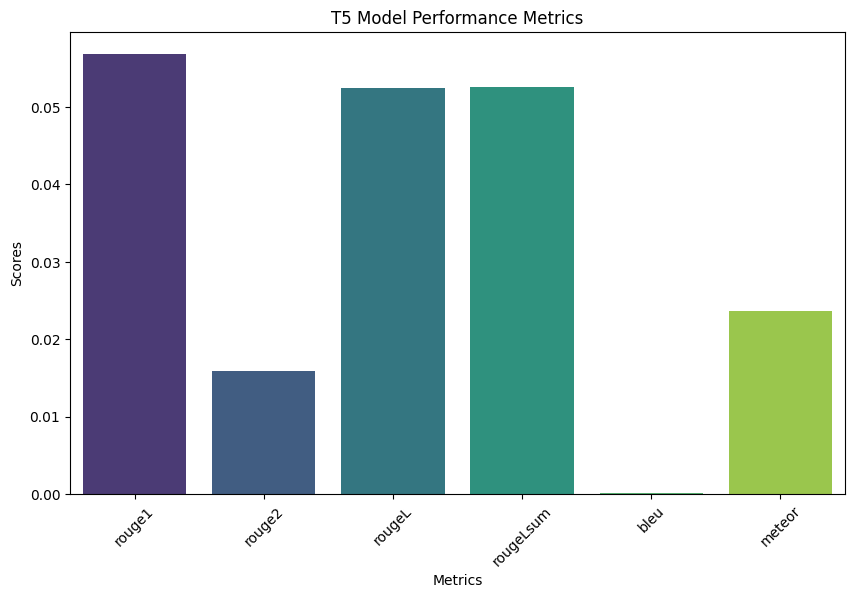

In [19]:
# Visualization Code for T5 Model Metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Load the trained model and tokenizer
model_path = "./results/t5_model"
tokenizer_path = "./results/t5_tokenizer"
t5_tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
t5_model = T5ForConditionalGeneration.from_pretrained(model_path)

# Ensure NLTK resources are downloaded
nltk.download('punkt')

# Function to generate answers and compute metrics
def test_model(test_data, tokenizer, model):
    prefix = "answer the question: "

    def generate_answer(question):
        input_text = prefix + question
        input_ids = tokenizer.encode(input_text, return_tensors='pt').to(model.device)
        output_ids = model.generate(
            input_ids,
            max_length=50,
            num_beams=5,
            early_stopping=True
        )
        answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return answer

    test_data['generated_answer'] = test_data['question'].apply(generate_answer)

    decoded_preds = test_data['generated_answer'].tolist()
    decoded_labels = test_data['answer'].tolist()

    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    meteor = evaluate.load("meteor")

    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)

    metrics = {
        "rouge1": rouge_result['rouge1'],
        "rouge2": rouge_result['rouge2'],
        "rougeL": rouge_result['rougeL'],
        "rougeLsum": rouge_result['rougeLsum'],
        "bleu": bleu_result['bleu'],
        "meteor": meteor_result['meteor']
    }

    return metrics, test_data

# Prepare a sample test dataset
test_sample = test_data.sample(n=10, random_state=42)  # Adjust the sample size as needed

# Test the model
metrics, test_results = test_model(test_sample, t5_tokenizer, t5_model)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame([metrics])

# Convert test results to DataFrame for display
test_results_df = test_results[['question', 'answer', 'generated_answer']]

# Display metrics in table form
print("Evaluation Metrics:")
print(tabulate(metrics_df, headers='keys', tablefmt='psql'))

# Display sample test results in table form
print("\nSample Test Results:")
print(tabulate(test_results_df, headers='keys', tablefmt='psql'))

# Visualization of Metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(), x='variable', y='value', palette='viridis')
plt.title('T5 Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.show()
